In [1]:
import pandas as pd
import numpy as np
from functools import reduce
from datetime import datetime
import missingno as msno

In [2]:
# These are the datasets uploaded by Jacob to blob storage:
df_app = pd.read_parquet('../do_not_commit/Datasets/AppErrorEvents.parquet')
df_win = pd.read_parquet('../do_not_commit/Datasets/WindowsErrorEvents.parquet')
df_hang = pd.read_parquet('../do_not_commit/Datasets/AppHangEvents.parquet')


Do this in one or two ways:
1. Add use suffixes= in pd.merge() to explicitly assign each column/variable to its original error type.
2. Combine values for common columns into the same column, add a new column for each of the 4 for its error type, e.g. "Hang", and not assign column suffixes (use pd.concat([dataframes])).

Given from the original XML exercise columns with the same name in different sets represented the same variable, preferred approach is #2.


In [3]:
print(len(df_app))
print(len(df_win))
print(len(df_hang))

268149
9836
40811


In [4]:
df_app['error_type'] = "Application"
df_win['error_type'] = 'Windows'
df_hang['error_type'] = 'Hang'

In [5]:
events = pd.concat([df_app, df_win, df_hang])
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318796 entries, 4740 to 7532
Data columns (total 72 columns):
 #   Column                                Non-Null Count   Dtype         
---  ------                                --------------   -----         
 0   RWB_EVENTRAWRESULTITEM_ID             318796 non-null  int64         
 1   RWB_ETL_EVENT_DESTINATION_IDENTIFIER  318796 non-null  int64         
 2   RWB_CREATE_TIMESTAMP                  318796 non-null  object        
 3   RWB_EFFECTIVE_DATE                    318796 non-null  object        
 4   ID                                    318796 non-null  int64         
 5   ClientItemKey                         318796 non-null  int64         
 6   LogName                               0 non-null       object        
 7   ProviderName                          318796 non-null  object        
 8   ProviderGUID                          318796 non-null  object        
 9   EventID                               318796 non-null  int

<AxesSubplot:>

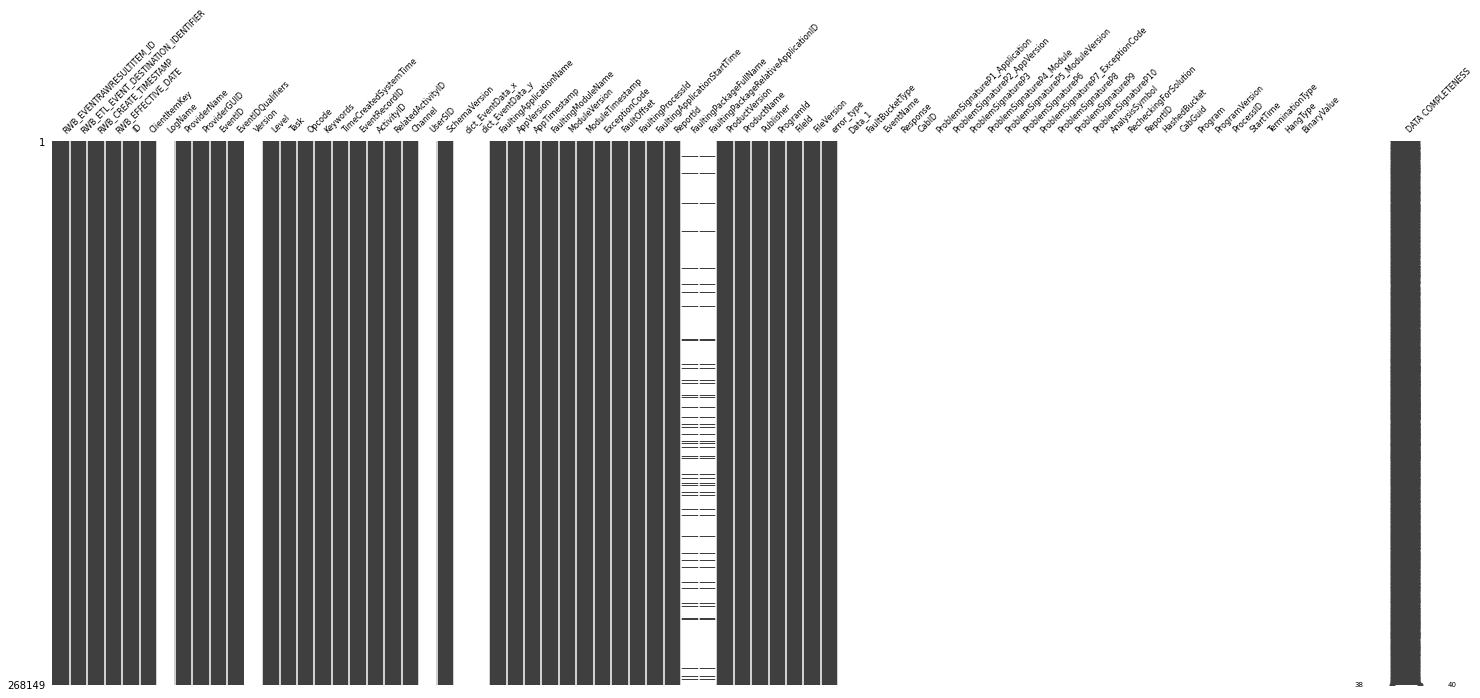

In [6]:
msno.matrix(events[events['error_type'] == 'Application'], labels=True, fontsize=8)

<AxesSubplot:>

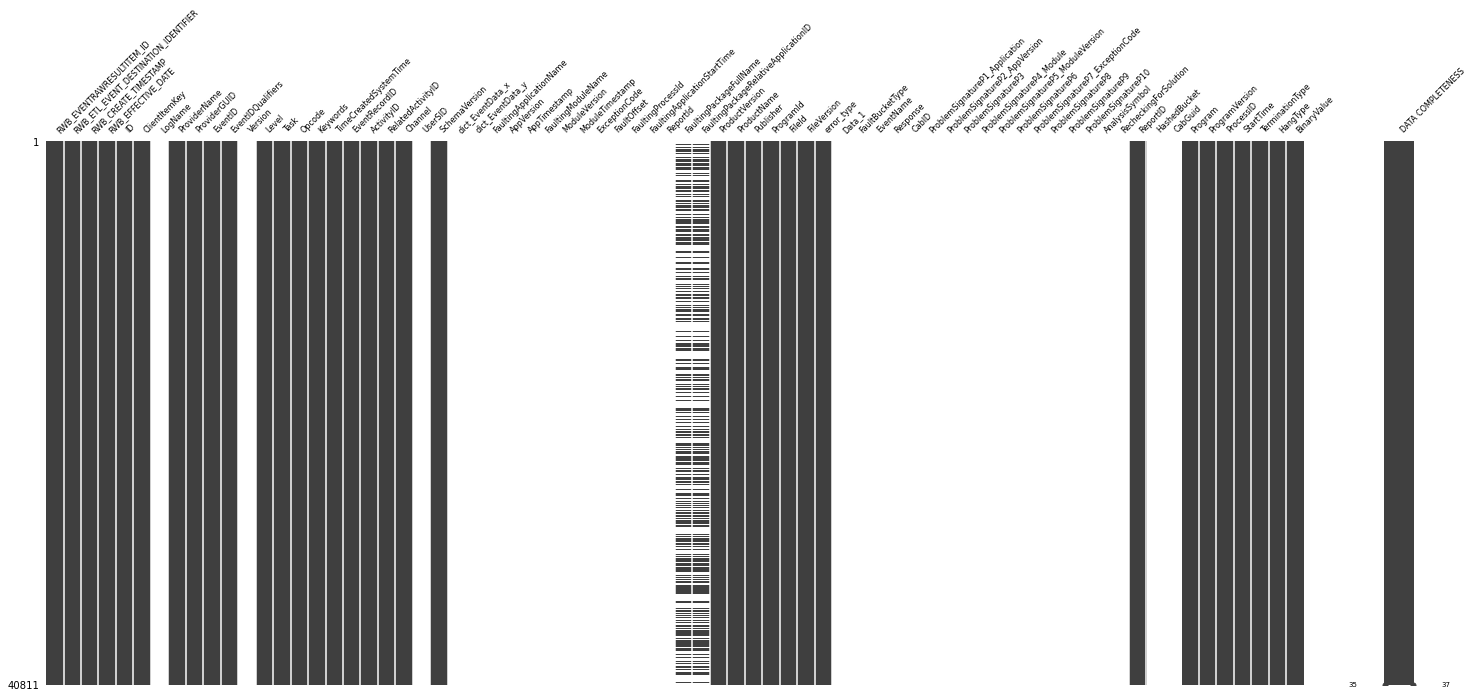

In [7]:
msno.matrix(events[events['error_type'] == 'Hang'], labels=True, fontsize=8)

<AxesSubplot:>

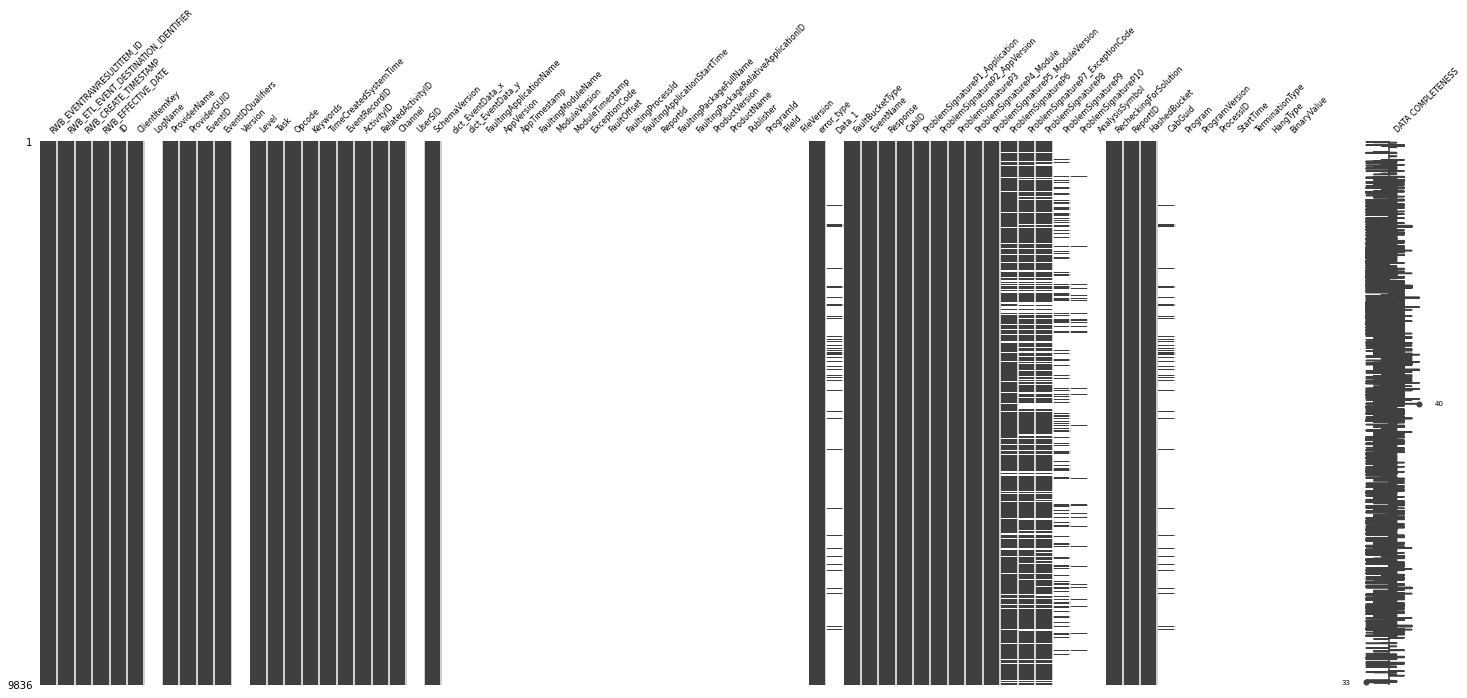

In [8]:
msno.matrix(events[events['error_type'] == 'Windows'], labels=True, fontsize=8)


# Join Machine data with Events data.


In [9]:
# From Azure database - takes about 15m-20m to load:
machines = pd.read_excel('../do_not_commit/Datasets/Persist_System_DISC.xlsx', )

<AxesSubplot:>

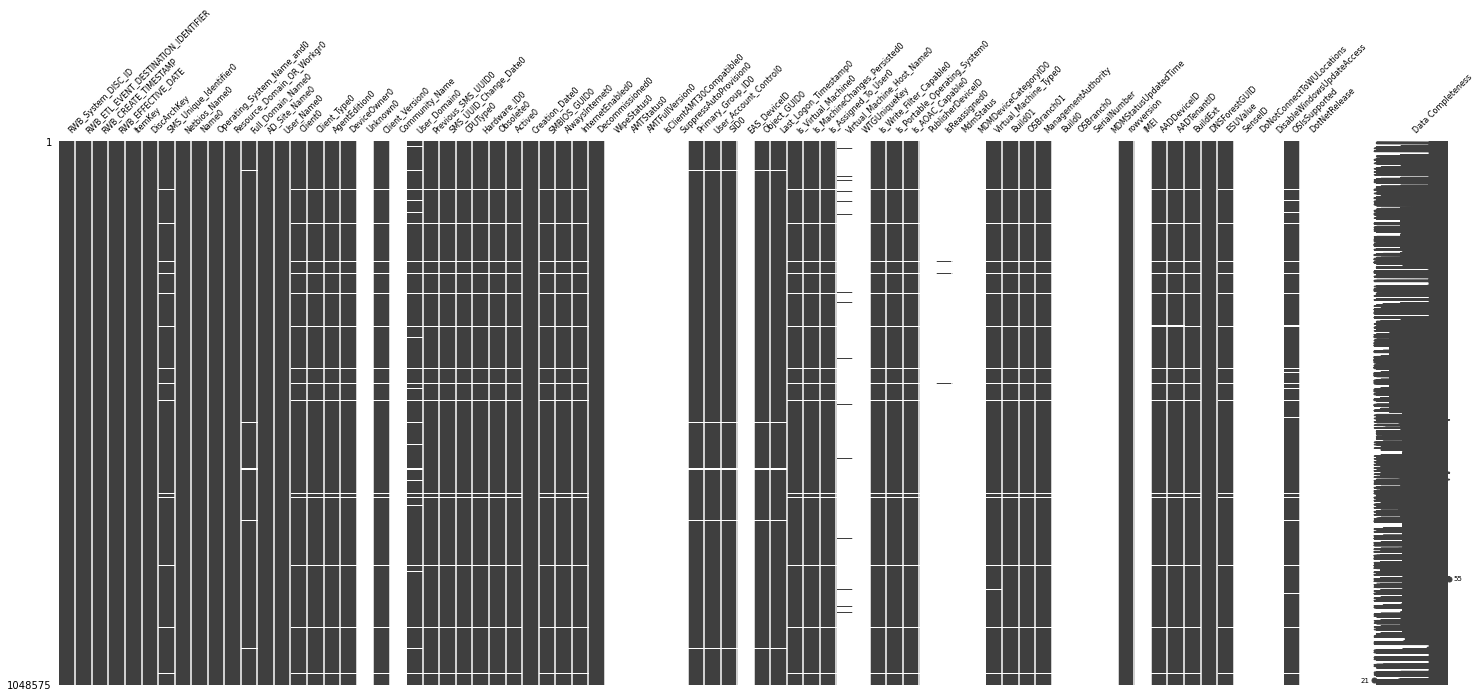

In [10]:
msno.matrix(machines, labels=True, fontsize=8)

In [11]:
# From blob storage:
incs = pd.read_csv('../do_not_commit/Datasets/ServiceNow_Incident.csv', low_memory=False)

<AxesSubplot:>

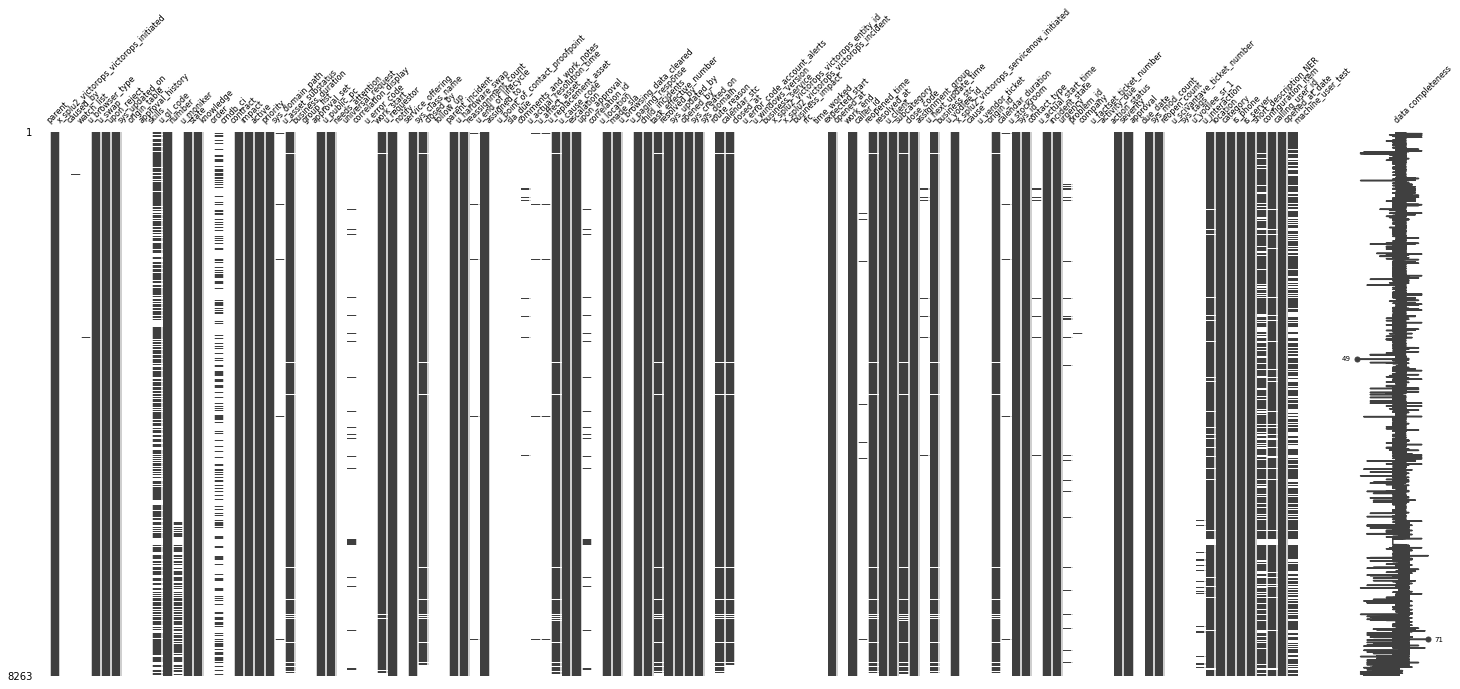

In [12]:
msno.matrix(incs, labels=True, fontsize=8)

In [13]:
machines['ClientItemKey'] = machines['ItemKey'].copy()

In [14]:
machines_events = events.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])

In [15]:
machines_events.sample(5)

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,LogName,ProviderName,ProviderGUID,EventID,...,HashedBucket,CabGuid,Program,ProgramVersion,ProcessID,StartTime,TerminationType,HangType,BinaryValue,Name0
64816,3294736,3501,2023-03-08 08:46:19 -06:00,2023-03-08,72057594083147185,16812356,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PWF-L-U33390
205093,5699010,6539,2023-04-26 08:46:33 -05:00,2023-04-26,72057594085603803,16803831,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIT-L-U30150
71979,3008986,3129,2023-03-02 08:46:22 -06:00,2023-03-02,72057594082859371,16814797,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LDN-L-E17395
161034,220752,812,2023-01-10 09:10:11 -06:00,2023-01-10,72057594080037286,16814482,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TIB-L-U30922
72639,3021149,3129,2023-03-02 08:46:22 -06:00,2023-03-02,72057594082871777,16794466,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-L-U26479


<AxesSubplot:>

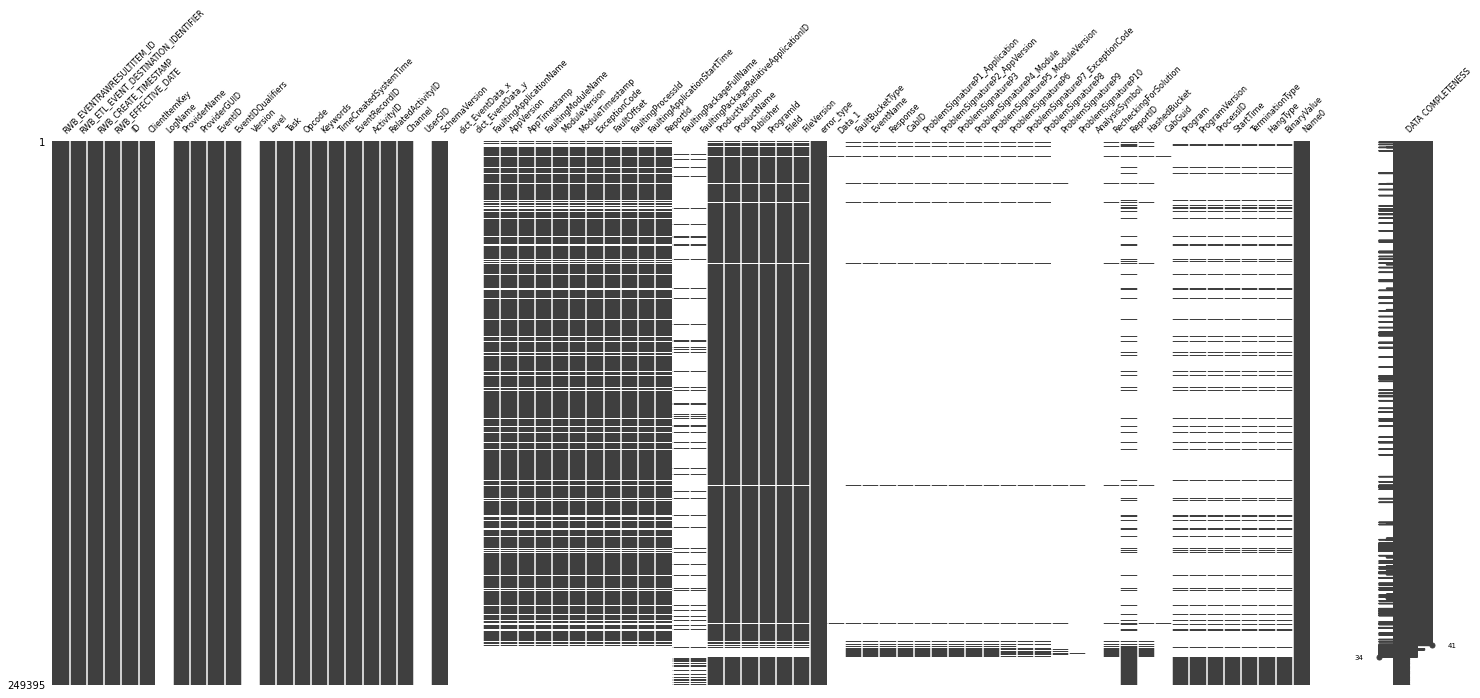

In [16]:
msno.matrix(machines_events, labels=True, fontsize=8)

<AxesSubplot:>

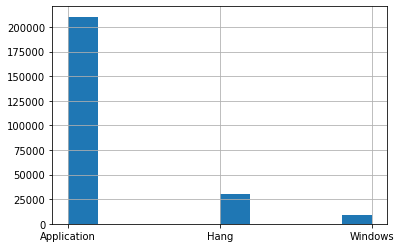

In [17]:
machines_events.sort_values(by=['error_type'])['error_type'].hist()


# Join Machines data with Boot data.


In [18]:
df_boot = pd.read_parquet('../do_not_commit/Datasets/BootEvents.parquet')
print(len(df_boot))

1593485


<AxesSubplot:>

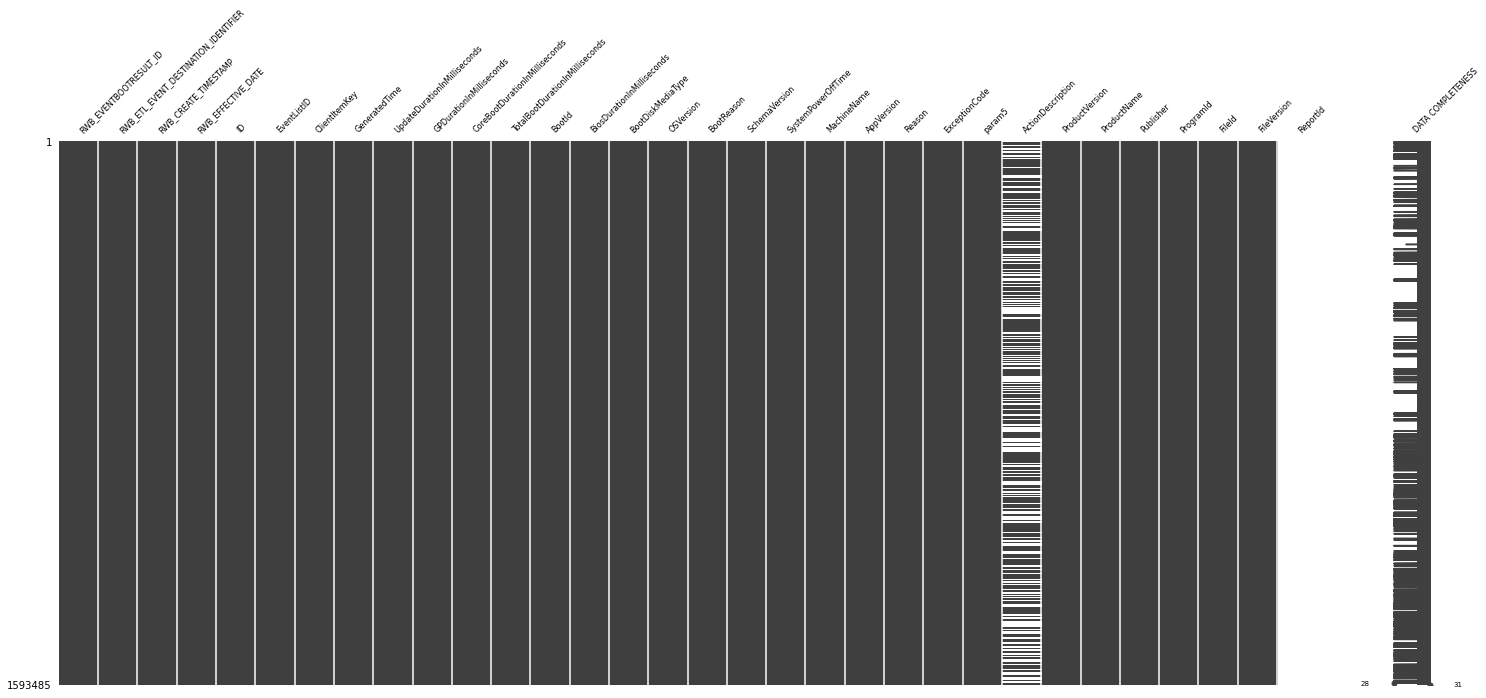

In [21]:
msno.matrix(df_boot, labels=True, fontsize=8)

In [22]:
df_boot['error_type'] = 'Boot'

In [23]:
common_columns = reduce(np.intersect1d, (df_app.columns, df_boot.columns, df_hang.columns, df_win.columns))
common_columns

array(['ClientItemKey', 'ID', 'RWB_CREATE_TIMESTAMP',
       'RWB_EFFECTIVE_DATE', 'RWB_ETL_EVENT_DESTINATION_IDENTIFIER',
       'SchemaVersion', 'error_type'], dtype=object)

In [24]:
df_boot['BootId'] = df_boot['BootId'].dt.strftime('%Y-%m-%d')

In [25]:
machines_boot = df_boot.merge(machines[['RWB_EFFECTIVE_DATE', 'ClientItemKey', 'Name0']], on=['RWB_EFFECTIVE_DATE', 'ClientItemKey'])

In [26]:
machines_boot

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,ActionDescription,ProductVersion,ProductName,Publisher,ProgramId,FileId,FileVersion,ReportId,error_type,Name0
0,947407,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043078438,3,16809009,2023-01-31 23:05:38.750,0,0,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,CHT-D-U27411
1,947576,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043078607,3,16795727,2023-01-31 23:53:57.723,0,0,...,None,8751,Microsoft® Windows® Operating System,Microsoft Corporation,00009D7160A474045C17F6CB8AEC9EA6F61300000000,0000D2A42C5059DB9D3A20C0944004ADE9B2584A27F3,1316,None,Boot,MHN-D-U27028
2,947577,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043078608,3,16795727,2023-01-31 23:53:57.723,0,0,...,Your computer will restart at 1/30/2023 7:00:4...,11882,Endpoint Configuration Manager,Microsoft Corporation,0000AC84AF65760157FA6165F4EB441A1C9D00000000,0000756F01C4A36B3645E10FE6CC99C76511D107E598,1194,None,Boot,MHN-D-U27028
3,947578,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043078609,3,16795727,2023-01-31 23:53:57.723,0,8000,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,MHN-D-U27028
4,947644,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043078675,3,16797689,2023-02-01 00:18:51.667,0,0,...,Your computer will restart at 1/30/2023 7:00:4...,11882,Endpoint Configuration Manager,Microsoft Corporation,0000AC84AF65760157FA6165F4EB441A1C9D00000000,0000756F01C4A36B3645E10FE6CC99C76511D107E598,1194,None,Boot,GRH-D-U28259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848628,1486372,8149,2023-05-21 08:35:27 -05:00,2023-05-21,72057594043644392,3,16800008,2023-05-20 20:16:41.707,0,111,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,WAU-D-U29279
848629,1486376,8149,2023-05-21 08:35:27 -05:00,2023-05-21,72057594043644396,3,16795500,2023-05-20 20:19:30.230,0,11689,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,ANP-D-U27067
848630,1486377,8149,2023-05-21 08:35:27 -05:00,2023-05-21,72057594043644397,3,16790511,2023-05-20 20:19:35.780,0,8764,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,WAK-D-U14010
848631,1486381,8149,2023-05-21 08:35:27 -05:00,2023-05-21,72057594043644401,3,16791224,2023-05-20 20:22:59.867,0,11402,...,Reboot initiated by NightWatchman 7.3,19982,NightWatchman,1E,000048C1361553810B674F3E6F986C5B9D8F00000000,00001F9D35B393AA598CB0FE68DE5F5E6D16E39CA7B1,623,None,Boot,RBK-D-U14104



#### Join INCs to machine + event.


In [27]:
# TimeCreatedSystemTime is all NaT.
# Use 'GeneratedTime' or 'BootId' instead of 'TimeCreatedSystemTime' for 'Boot' errors?
machines_events[machines_events['error_type'].isin(['Application', 'Hang'])].sample(5)

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,LogName,ProviderName,ProviderGUID,EventID,...,HashedBucket,CabGuid,Program,ProgramVersion,ProcessID,StartTime,TerminationType,HangType,BinaryValue,Name0
120496,1552462,1203,2023-01-31 09:08:50 -06:00,2023-01-31,72057594081391353,16804727,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-L-U20779
229750,5019133,5733,2023-04-13 08:46:22 -05:00,2023-04-13,72057594084915416,16813338,None,Application Hang,{00000000-0000-0000-0000-00000000000,1002,...,NaN,NaN,LockApp.exe,2.0,3e2c,01d9690a75d2982e,4294967295,Cross-thread,430072006F00730073002D007400680072006500610064...,CHI-L-U33904
193559,6238571,7159,2023-05-06 08:46:12 -05:00,2023-05-06,72057594086146651,16810443,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,RAC-L-U31640
18456,4473627,4989,2023-04-01 08:46:09 -05:00,2023-04-01,72057594084364038,16814347,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MIL-L-U33115
9632,4785392,5361,2023-04-07 08:46:24 -05:00,2023-04-07,72057594084678875,16814896,None,Application Error,{00000000-0000-0000-0000-00000000000,1000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHI-L-U31125


In [28]:
# DateTime formatting.
incs['opened_at'] = pd.to_datetime(incs['opened_at'])
incs['opened_at_formatted'] = incs['opened_at'].dt.strftime('%Y-%m-%d')
machines_events['TimeCreatedSystemTimeFormatted'] = machines_events['TimeCreatedSystemTime'].dt.strftime('%Y-%m-%d')

In [29]:
# incs_merged = machines_merged.merge(incs, left_on='Name0', right_on='configuration_item')
incs_merged = machines_events.merge(incs, left_on=['Name0', 'TimeCreatedSystemTimeFormatted'], right_on=['configuration_item', 'opened_at_formatted'])

In [30]:
print(len(incs_merged))

4303


<AxesSubplot:>

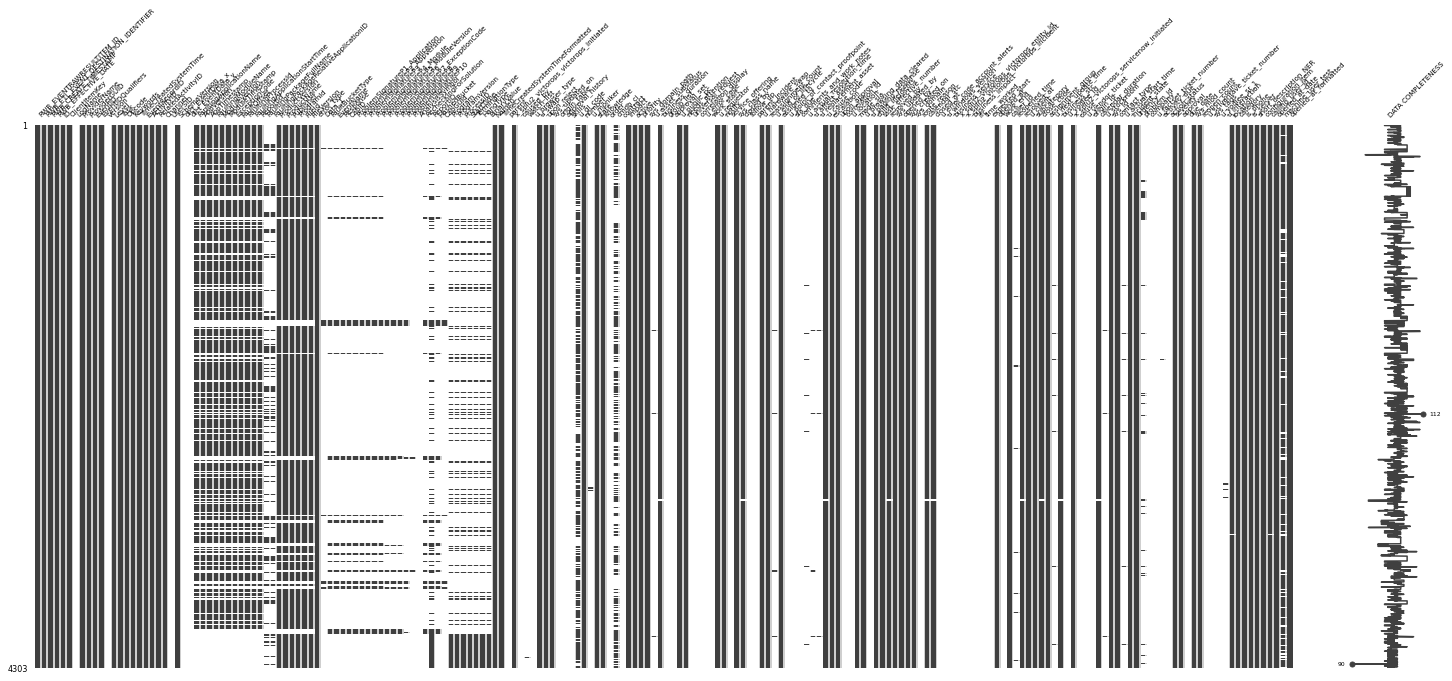

In [31]:
msno.matrix(incs_merged, labels=True, fontsize=7)

In [33]:
# Issues:
# If a separate error is recorded on the same day as an unrelated INC, the two are associated (.loc[210, :])
# Possible fix: reduce the time window from "same day" to "within x hours," e.g. +/-2hrs.
incs_merged.sample(5)[[
    'error_type',
    # 'OSVersion',
    'FaultingApplicationName',
    'FaultingModuleName',
    # 'FaultingPackageFullName',
    'ProductName',
    'Program',
    'category',
    'subcategory',
    'short_description_NER'
]]

,error_type,FaultingApplicationName,FaultingModuleName,ProductName,Program,category,subcategory,short_description_NER
2654,Windows,NaN,NaN,NaN,NaN,Microsoft Office 365,Authentication,Can not access Outlook or any applications. ...
1479,Application,powershell.exe,BIOSIntf.dll,Microsoft® Windows® Operating System,NaN,Microsoft Teams,Application Error,after installed teams on mobile the laptop app...
3851,Application,ScanProServer.exe,KERNELBASE.dll,ScanProServer,NaN,ftni_scan_check_pro,Application Error,FTNI Scanner not connecting to computer
3482,Application,ShellExperienceHost.exe,KERNELBASE.dll,Microsoft® Windows® Operating System,NaN,Microsoft Excel 365,Application Error,Excel Documents Not Saving
3789,Application,ShellExperienceHost.exe,KERNELBASE.dll,Microsoft® Windows® Operating System,NaN,microsoft_windows,windows_profile,"When working at front desk computer, Windows s..."


In [34]:
incs_merged['number'].unique()

array(['INC0515837', 'INC0515517', 'INC0516099', ..., 'INC0518392',
       'INC0516861', 'INC0516263'], dtype=object)

In [35]:
# INCs w/ multiple events assc. may attribute the event to the INC
# despite the event occurring *after* the INC was already filed.
incs_merged[incs_merged['number'] == 'INC0515837'][[
    'TimeCreatedSystemTimeFormatted',
    'TimeCreatedSystemTime',
    'opened_at',
    'opened_at_formatted',
    'Name0',
    'configuration_item',
    'number',
    'FaultingApplicationName',
    'FaultingModuleName',
    'short_description_NER'
]]

,TimeCreatedSystemTimeFormatted,TimeCreatedSystemTime,opened_at,opened_at_formatted,Name0,configuration_item,number,FaultingApplicationName,FaultingModuleName,short_description_NER
0,2023-04-10,2023-04-10 13:28:18.740,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,powershell.exe,BIOSIntf.dll,URGENT| Repeated Blue Screen of Death
1,2023-04-10,2023-04-10 20:23:56.900,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,WINWORD.EXE,s_llqgukqx.dll,URGENT| Repeated Blue Screen of Death
2,2023-04-10,2023-04-10 17:35:27.050,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,NaN,NaN,URGENT| Repeated Blue Screen of Death
3,2023-04-10,2023-04-10 01:44:28.930,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,spoolsv.exe,unknown,URGENT| Repeated Blue Screen of Death
4,2023-04-10,2023-04-10 00:01:17.457,2023-04-10 11:20:00,2023-04-10,TIB-L-U32432,TIB-L-U32432,INC0515837,NaN,NaN,URGENT| Repeated Blue Screen of Death



#### Join INCs to machine + boot.


In [36]:
incs_boot = machines_boot.merge(incs, left_on=['Name0', 'BootId'], right_on=['configuration_item', 'opened_at_formatted'])

In [37]:
incs_boot

,RWB_EVENTBOOTRESULT_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,EventListID,ClientItemKey,GeneratedTime,UpdateDurationInMilliseconds,GPDurationInMilliseconds,...,location,category,is_phone,is_server,short_description_NER,configuration_item,calling_user_id,opened_at_date,machine_user_test,opened_at_formatted
0,949656,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0,0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
1,949657,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0,0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
2,949659,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,3,16792948,2023-02-01 09:22:37.737,0,0,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0,0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
3,949655,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,3,16792948,2023-02-01 09:22:37.737,0,13514,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0,0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
4,949660,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,3,16792948,2023-02-01 09:22:37.737,0,11379,...,{'link': 'https://rwbaird.service-now.com/api/...,network_cabling,0,0,pc not connecting to network,ASH-D-U25377,1521.0,2023-01-31,ASH-D-U25377,2023-01-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5312,1483399,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641419,3,16813765,2023-05-19 23:30:53.757,0,16809,...,{'link': 'https://rwbaird.service-now.com/api/...,laptop,0,0,FW: Screen shot,PIT-L-U21589,9094.0,2023-05-19,PIT-L-U21589,2023-05-19
5313,1483746,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641766,3,16811183,2023-05-20 01:39:37.853,53159,13837,...,{'link': 'https://rwbaird.service-now.com/api/...,Microsoft Outlook 365,0,0,Outlook rules not working / general slowness,DUR-L-U32898,3944.0,2023-05-19,DUR-L-U32898,2023-05-19
5314,1483746,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641766,3,16811183,2023-05-20 01:39:37.853,53159,13837,...,{'link': 'https://rwbaird.service-now.com/api/...,Microsoft Outlook 365,0,0,Outlook rules not working / general slowness,DUR-L-U32898,3944.0,2023-05-19,DUR-L-U32898,2023-05-19
5315,1484152,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,3,16795890,2023-05-20 04:24:55.647,0,18555,...,{'link': 'https://rwbaird.service-now.com/api/...,citrix,0,0,Citrix VDA needed asap- CHE - D - U27461,CHE-D-U27461,12384.0,2023-05-19,CHE-D-U27461,2023-05-19


In [38]:
# Dropping columns with nothing in them.
incs_merged.dropna(axis=1, how='all', inplace=True)


#### How many multiple INCs were filed on the same day for a given machine?


In [39]:
grouped_counts = incs.groupby(['opened_at_formatted', 'configuration_item']).size()
print(grouped_counts[grouped_counts > 1].sum())
grouped_counts[grouped_counts > 1]

416


opened_at_formatted  configuration_item
2023-01-03           CHI-L-U33511          2
                     LOE-D-U25294          2
                     MWE-L-U29955          2
2023-01-04           MIL-L-U21470          2
                     MIL-L-U30749          2
                                          ..
2023-07-05           MIL-L-U34247          2
                     TCF-L-U34494          2
2023-07-06           MIL-D-U25226          2
2023-07-10           CHI-L-U34590          2
                     PIT-L-U33237          2
Length: 200, dtype: int64


# Explore 'Application' errors.


In [40]:
df = pd.concat([incs_merged, incs_boot])

In [41]:
# Dropping columns with nothing in them.
df.dropna(axis=1, how='all', inplace=True)

In [42]:
# df = df[df['error_type'] == 'Application']

<AxesSubplot:>

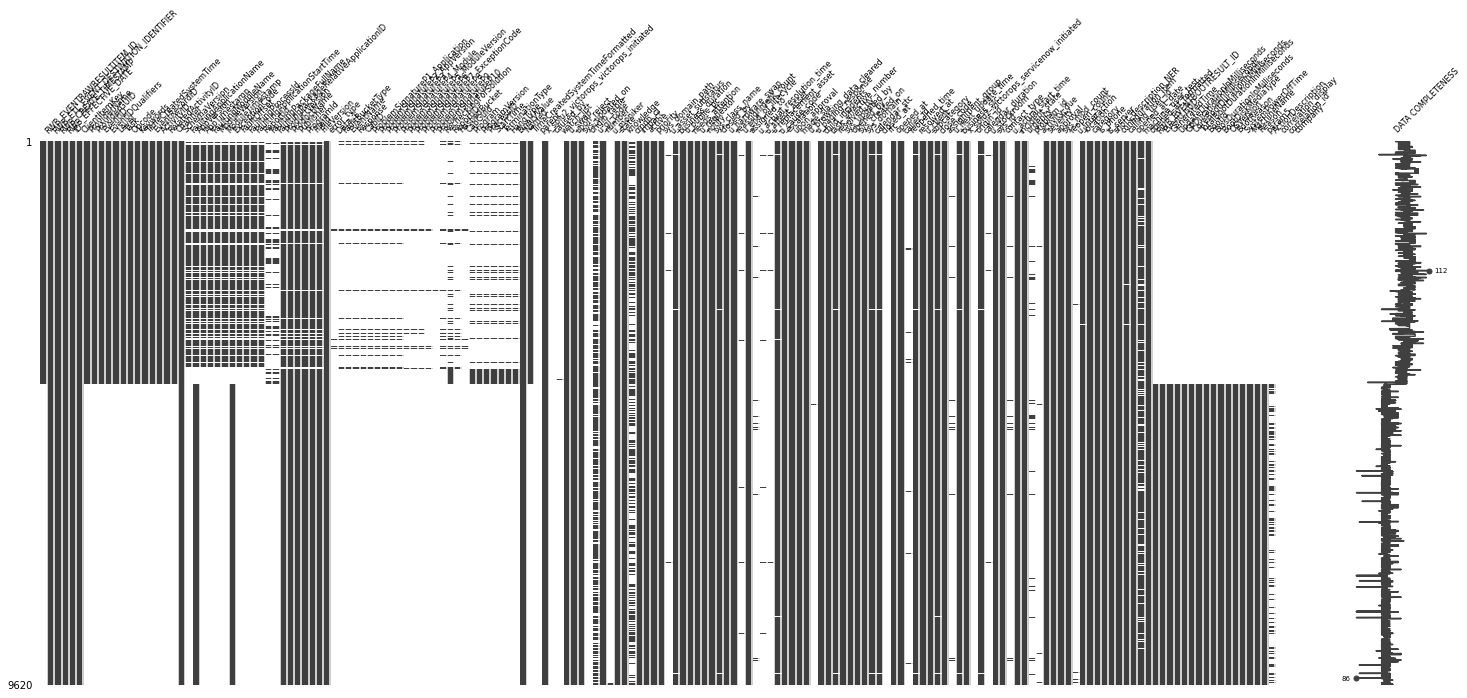

In [43]:
msno.matrix(df, labels=True, fontsize=8)

<AxesSubplot:>

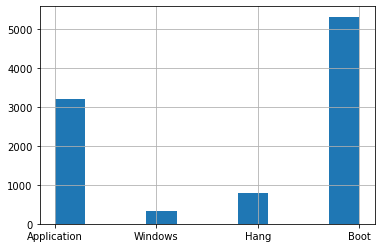

In [44]:
df['error_type'].hist()

In [45]:
df[df['error_type'] == 'Boot']

,RWB_EVENTRAWRESULTITEM_ID,RWB_ETL_EVENT_DESTINATION_IDENTIFIER,RWB_CREATE_TIMESTAMP,RWB_EFFECTIVE_DATE,ID,ClientItemKey,ProviderName,ProviderGUID,EventID,EventIDQualifiers,...,OSVersion,BootReason,SystemPowerOffTime,MachineName,Reason,param5,ActionDescription,correlation_display,correlation_id,company
0,NaN,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080687,16792948,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-01-31T19:08:07.6267429Z,C:\Windows\System32\RuntimeBroker.exe (ASH-D-U...,Other (Unplanned),power off,None,NaN,NaN,NaN
1,NaN,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080688,16792948,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-01-31T19:13:33.1447390Z,C:\Windows\System32\RuntimeBroker.exe (ASH-D-U...,Other (Unplanned),restart,None,NaN,NaN,NaN
2,NaN,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080690,16792948,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-01-31T19:20:43.1740171Z,C:\Windows\System32\RuntimeBroker.exe (ASH-D-U...,Other (Unplanned),restart,None,NaN,NaN,NaN
3,NaN,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080686,16792948,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-01-31T07:00:10.9237968Z,C:\Program Files\1E\NightWatchman\NwmSvc.exe (...,No title for this reason could be found,restart,Reboot initiated by NightWatchman 7.3,NaN,NaN,NaN
4,NaN,1251,2023-02-01 09:02:13 -06:00,2023-02-01,72057594043080691,16792948,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-01-31T19:50:51.6796410Z,C:\Windows\System32\RuntimeBroker.exe (ASH-D-U...,Other (Unplanned),restart,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5312,NaN,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641419,16813765,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-05-19T17:06:20.4004413Z,C:\windows\system32\winlogon.exe (PIT-L-U21589),No title for this reason could be found,restart,None,NaN,NaN,NaN
5313,NaN,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641766,16811183,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-05-19T09:30:35.8805861Z,C:\Program Files\1E\NightWatchman\NwmSvc.exe (...,No title for this reason could be found,restart,Reboot initiated by NightWatchman 7.3,NaN,NaN,NaN
5314,NaN,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043641766,16811183,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-05-19T09:30:35.8805861Z,C:\Program Files\1E\NightWatchman\NwmSvc.exe (...,No title for this reason could be found,restart,Reboot initiated by NightWatchman 7.3,NaN,NaN,NaN
5315,NaN,8025,2023-05-20 08:35:27 -05:00,2023-05-20,72057594043642172,16795890,NaN,NaN,NaN,NaN,...,7227.0,1074.0,2023-05-19T06:00:10.8154752Z,C:\Program Files\1E\NightWatchman\NwmSvc.exe (...,No title for this reason could be found,restart,Reboot initiated by NightWatchman 7.3,NaN,NaN,NaN



#### How many INCs contain direct reference to BSOD?


In [46]:
len(df[df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")]['number'].unique())

55

<AxesSubplot:>

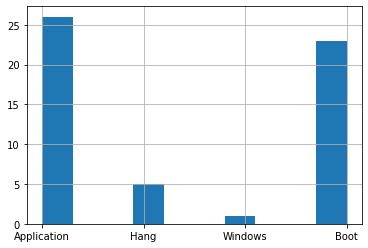

In [51]:
df[df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")].drop_duplicates('number', keep='first')['error_type'].hist()

In [67]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath"))].drop_duplicates('number', keep='first')[['error_type', 'FaultingApplicationName', 'FaultingModuleName', 'ExceptionCode']]

,error_type,FaultingApplicationName,FaultingModuleName,ExceptionCode
0,Application,powershell.exe,BIOSIntf.dll,c0000005
119,Application,powershell.exe,BIOSIntf.dll,c0000005
379,Application,powershell.exe,BIOSIntf.dll,c0000005
681,Application,IntelAudioService.exe,ControlModule.dll,c0000005
864,Application,powershell.exe,BIOSIntf.dll,c0000005
890,Application,powershell.exe,BIOSIntf.dll,c0000005
932,Application,OUTLOOK.EXE,ntdll.dll,c0000374
1000,Application,RtkAudUService64.exe,RtkAudUService64.exe,c0000005
1182,Application,powershell.exe,BIOSIntf.dll,c0000005
1219,Hang,NaN,NaN,NaN


In [57]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Application')].drop_duplicates('number', keep='first')['FaultingApplicationName']

0                         powershell.exe
119                       powershell.exe
379                       powershell.exe
681                IntelAudioService.exe
864                       powershell.exe
890                       powershell.exe
932                          OUTLOOK.EXE
1000                RtkAudUService64.exe
1182                      powershell.exe
1246                             dwm.exe
1356                      powershell.exe
1386                           EXCEL.EXE
1427               IntelAudioService.exe
1454                      powershell.exe
1482                      powershell.exe
1643                      WavesSvc64.exe
1646                      powershell.exe
1688    svchost.exe_BrokerInfrastructure
1737                      powershell.exe
1953                      powershell.exe
2020                      powershell.exe
2627               svchost.exe_DiagTrack
2754                 igfxCUIServiceN.exe
2876                        EmPSHost.exe
2942            

In [59]:
df[(df['short_description_NER'].str.contains("(?i)Blue Screen|BSOD|[Dd]eath")) & (df['error_type'] == 'Boot')].drop_duplicates('number', keep='first')['short_description_NER']

787                              BSOD- No stop code error
969                                                  BSOD
1049                                                 BSOD
1084                 Plugging in headphones prompted BSOD
1308    BSOD at Startup- Stop Code WHEA- uncorrectable...
1421    Received the blue screen of death <CARDINAL> t...
1453                                                 BSOD
1721                             Laptop BSOD'd 5/10/20223
1824    Laptop Overheating, Blue Screen Crashing- Unit...
1873    Repeated Blue Screen Error: Device did not sta...
1943    BSOD at Startup- Get stuck at Dell logo before...
1977                        Blue Screen Crashes on laptop
1979                  Laptop Blue Screening Every Morning
2139                                        BSOD- Startup
2171                                Laptop BSOD on U30366
2177               BSOD- Device did not startup correctly
2233                   Multiple BSODs over past few weeks
2251          


#### What is the distribution of FaultApplicationName among INCs?


In [53]:
df_check = df[df['error_type'] == 'Application']

In [54]:
df_check['FaultingApplicationName'].value_counts()

powershell.exe                 507
EXCEL.EXE                      268
Acrobat.exe                    182
RuntimeBroker.exe              146
SearchApp.exe                  145
                              ... 
BarcoClickShareSvc.exe           1
Passport.exe                     1
AdobeNotificationClient.exe      1
DesktopInfo.exe                  1
DellOptimizer.exe                1
Name: FaultingApplicationName, Length: 136, dtype: int64


#### What is the distribution of modules among INCs?


In [55]:
df_check['FaultingModuleName'].value_counts()

KERNELBASE.dll         824
BIOSIntf.dll           504
ntdll.dll              288
Windows.UI.Xaml.dll    115
WavesSvc64.exe         110
                      ... 
b_puuhpvka.dll           1
o_rrrkctrn.dll           1
m_vstosktn.dll           1
f_sbnfpoqx.dll           1
j_zpupthsh.dll           1
Name: FaultingModuleName, Length: 387, dtype: int64


#### Which exception codes are most common among INCs?


In [56]:
df_check[['FaultingApplicationName', 'ExceptionCode']].value_counts()

FaultingApplicationName     ExceptionCode
powershell.exe              c0000005         504
ShellExperienceHost.exe     c000027b         137
WavesSvc64.exe              c0000005         110
Thomson One 5.0.exe         c0000005         103
TextInputHost.exe           c000027b          95
                                            ... 
PfuSshMonWCFHost.exe        c0000374           1
EXCEL.EXE                   80131623           1
Thomson One 5.0.exe         4000001f           1
Thomson One 5.0 Chrome.exe  c0000005           1
Thomson One 5.0.exe         c000001d           1
Length: 253, dtype: int64